This project creates a model that classifies handwritten 3s and 7s from the MNIST sample dataset.

In [1]:
!pip install -Uqq fastai

In [2]:
!pip install -Uqq fastbook

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
Path.BASE_PATH = path

.BASE_PATH is an attribute to path that tells where the starting point is.  
If you run 'path' it shows you where it is

In [6]:
path

Path('.')

In [7]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

This lets us see what is in the directory.

In [8]:
type(path)

pathlib.PosixPath

pathlib is part of a Python standard library but doesn't have 'ls' command  so we have to add .ls. For instance path.ls().

In [9]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

This allows us to see what is in the train folder.

3s and 7s are labels/targets in the dataset.

In [10]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

This allows us to sort the data so that it is consistent/ get the same order of files.

In [11]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [12]:
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [13]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

This allows us to see one image from the 3s folder after sorting.

In [14]:
type(im3)

PIL.PngImagePlugin.PngImageFile

The im3 image is a png file.  
We need to represent this in number format as everything is represented as numbers in computers.  
To view the number that represent this image we convert it to a Numpy array or PyTorch tensor.

To convert it to a Numpy array:


In [15]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

This shows us an index of a number at the top left from 4 up to the number before 10. (It does not include 10).  
[4:10, 4:10] represents [rows, columns]

There are 8 bit integer, thus between 0 and 255.

To convert to a PyTorch Tensor:
    

In [16]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

PyTorch tensors and Numpy arrays behave the same but PyToch tensors can be computed on GPU and not onlu in CPUs like numpy arrays.

In [17]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


im3_t = tensor(im3) -> grabs im3 and turns it to a tensor.  
df = pd.DataFrame(im3_t[4:15, 4:22]) -> grabs part of the image, that is [4:15, 4:22]  
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') -> turns it to a panda's dataframe


Reason for turning it to a panda dataframe is because panda's dataframe has a convenient thing called background_gradient() that turns a background into a gradient.

In the output, 0s are the whites and 255 are the blacks. Then there are shades of grey that vary between 0 and 255.

## Creating a model that detects a 3

Idea is, if it doesn't recognise that a number is a 3, then it must be a 7.

### Pixel Similarity

- Find the average pixel value forevery pixe; of the threes and sevens.  
- The two group averages define the "ideal" 3 and 7.  
- Then to classify an image as a digit, we see which of these two ideal digits the image is similar to.

#### Create a baseline model

Baseline model -> a simple model which you are confident that it can perform reasonably well, should be simple to implement and easy to test.

First, we need to list all the images of sevens and threes as tensors.

In [18]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

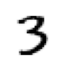

In [19]:
show_image(three_tensors[1]);

We can now display one of the 3s in the three_tensor list.  
Remember, this is a tensor and not a PIL image as we had seen before. Jupyter doesn't know how to display tensor so we use show_image().

We now need to get the average of all those 3s and 7s.  
First we need to change three_tensors and seven_tensors from lists, which can't easily do mathematical computations.

In [20]:
type(seven_tensors)

list

So we first stack all these 28×28 pixels images on top of each other to create like a 3D cube of images, quite like a tensor.

In [21]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This turns the list to a tensor so the shape is now 6131 by 28 by 28.  
More like a cube of height 6131 that is 28×28.

Now if we are going to find the mean, we need to change them to floating point values because we don't want to kind of have integers rounding off.  
Also, its kind of a standard in computer vision that when you are working with floats, expect them to be between 0 and 1, so we divide by 255 because they are between 0 and 255.

The output is a Rank 3 tensor as it has three axes.

In [22]:
len(stacked_threes.shape)

3

We can also get it from 'ndim' that stands for number of dimensions.

In [23]:
stacked_threes.ndim

3

Numpy tends to call it axis, PyTorch tends to call it dimension.

Rank -> Number of axes or dimensions in a tensor.  
Shape -> Size of each axis of a tensor.

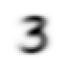

In [24]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

This gives us the mean of just the 0 axis, that is the mean across the images.  
Takes the mean across the 6131 axis.

When we show the image, we get the 'ideal' 3.

Now we, we can do the same for 7:

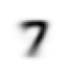

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This shows us the 'ideal' 7.

Now, let's grab a 3:

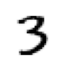

In [26]:
a_3 = stacked_threes[1]
show_image(a_3);

We can find if the a_3 is similar to the 'ideal' 3 or 7.  
The one that is more similar to, that's the answer.

We just can't add up the difference between the pixel of the image and the ideal digit because some differences will be negative and some will be positive and they'll cancel out. This will result in an image thats too dark in some places and too light in others.

To avoid this, we have to make them all positive values.  
This can be achieved by:  
1) Finding the absolute values (simply means removing the minus sign), the take the average. This is called the Mean Absolute Difference or L1 norm.  
2) Take the square of each difference and the take the mean then find the square root to undo the squaring. This is called Root Mean Squared Error or L2 norm.
    

In [27]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [28]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

We do for both 3 and 7.

The distance in terms of absolute from mean of 3 is 0.114 and mean of 7 is 0.1586 so its close to the mean of 3 than the mean of 7. Therefore, we can guess that its a 3 based on the mean absolute differences.  
This is same for the root mean squared error.

In the codes above, we don't have to write  minus abs() mean(), we can use L1_loss.  
Also, we don't have to write minus squared, we can write mse_loss, but it doesn't do the square root so we have to include .sqrt().

In [29]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

This can be found inside 'torch.nn.functional', which PyTorch recommends importing as F.

##### Numpy array and PyTorch tensors

To create an array or tensor, we can pass a list or lists or list of lists.

In [30]:
data = [[1, 2, 3], [4, 5, 6]]
arr = array(data)
tns = tensor(data)

In [31]:
# for numpy
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [32]:
#for PyTorch
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

To select a row:

In [33]:
tns[1]

tensor([4, 5, 6])

To select a column:
    

In [34]:
tns[:,1]

tensor([2, 5])

: means row because its in the fist spot so therefore ,: is the same as removing it.  
example:

In [35]:
tns[1,:]

tensor([4, 5, 6])

Is the same as,

In [36]:
tns[1]

tensor([4, 5, 6])

Combining the together:

In [37]:
tns[1, 1:3]

tensor([5, 6])

This gives the first row and everything from the first up to but not including the third column.

[start:end] -> means from start to end but not including end.

Using standard operators to add all elements by 1:


In [38]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Finding the type:

In [39]:
tns.type()

'torch.LongTensor'

Multiplying by a float:

In [40]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

Tensor automatically changes from a int to a float.

### Computing metrics using broadcasting

Is our model good enough?  
To quantify this, we must define a metric.

Metric -> a number which is calculated from the predictions of our model and the correct labels in our dataset, in order to tell us how good our model is.

We ought to check our model is by calculating the metric, using our validation set.

First, lets create a tensor of our threes and sevens from our valid directory.

The following code does the similar process as what we had done in our training set:

In [41]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

The code goes through through everything in the validation set of 3.ls() opens and turns them into a tensor then stacks them all up. Next, it turns them into a float by dividing by 255.  
Same is done for the 7 folder

Then we check the shape.

Idea is, we want to create a function is_3 that will return true if we think something is a 3. So we have to check whether the digit we are testing on is closer to the 'ideal' three or seven.

Let's create a function that takes the difference between two things, takes the absolute value and then takes the mean.

In [42]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

The mnist_distance function takes the difference between two tensors, takes their absolute value then takes the mean.

mean((-1,-2)) -> takes the mean of the last and the second last dimension.  
This is going to take the mean of kind of the x and y axes.

It returns a single number which is the distance a_3 from the mean3. This is the same value as we got earlier.

We need to do this for every image in the validation set so as to find the overall metric.

In [43]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1328, 0.1523, 0.1245,  ..., 0.1383, 0.1280, 0.1138]),
 torch.Size([1010]))

Broadcasting is a magic trick of Python that allows us to pass the whole validation set against the mean3.

In our case, it returns 1010 numbers.  
Here, we are doing a-b on the 1010 images on the validation set.

In [44]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

Gives us a Rank 3 tensor

In [45]:
mean3.shape

torch.Size([28, 28])

Gives us a Rank 2 tensor.

Broadcasting means if the two shapes don't match, if they matched it would just subtract every corresponding item. But because they don't match it actually acts as if there is 1010 versions of 28×28 (tensor of mean3). So its actually going to subtract this from every single one of mean3 tensor from every tensor of the validation set.

Broadcating requires us to first understand the idea of element-wise operation:

In [46]:
tensor([1, 2, 3]) + tensor([4, 5, 6])

tensor([5, 7, 9])

This is element-wise operation.  
These are rank-1 tensor of size 3. As they match,it takes the corresponding items and adds them together.

In [47]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

When we have different shapes as described before, what it ends up doing is copying mean3 1010 times and acts as if we had valid_3_tens minus 1010 copies of mean3.

Then we find the absolute value and call mean((-1, -2)).

We can now create is_3 function:

In [48]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x,mean7)

The function figures out if the distance between the image in question (x) and mean3 is less than the distance between the image in question (x) and mean7. If it is, then its a 3.

Let's check with a_3:

In [49]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Checks whether the image is a 3 and turns it into a float.  
If true, it becomes a 1. like in the above code.

Using broadcating, we can check the whole validation dataset.

In [50]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Now, we can calculate the accuracy of the threes and sevens by taking the average of the function for all 3s and 7s.

In [51]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This performs is_3 on our whole valid_3_tens and then turns that into float and takes the mean. Same is done for 7.

Accuracy is 91% for 3s, 98% for 7s and 95% for both.   
This is a good baseline.

## Gradient Descent

But in ML, according to Arthur Samuel, we don't have a function which has parameters that we are testing against some kind of measure of fitness and then using it to improve the parameters. We just did one step.

Suppose, we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of the actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance.

We need some way to get our model to become better and better as we keep iterating. 
Let's think of a function which has parameters. So instead of finding an ideal image and seeing how far away something is from the ideal image, what we could instead do is come up with a set of weights for each pixel.
So in place that you expect to find 3, you could give those high weights.

We can come up with a function where the probability of something being, for example an 8, is equal  to the pixel in the image(x) multiplied by some sort of weight(w) then we sum up.  

def pr_eight(x,w): return (x*w).sum()

So anywhere in the image we are looking at with high weights, its going to end up with a high probability.

x is the image represented as a vector.

So here are the steps that we are going to require, to turn this function into a machine learning classifier:  
1) We will start with a vector w(A vector is a Rank 1 tensor) containing random weights/parameters.  
2) Then, we will predict whether the number is a 3 or 7.  
3) Based on the predictions, calculate how good the model is (its loss).  
4) Key step -> Calculate the gradient, which measure for each weight, how  changing that weight would change the loss.  
5) Step/Change all the weights based on that calculation.  
6) Go back to step 2 and repeat the process.  
7) ... repeat until you decide to stop the training process (for instance because the model is good enough).  

These steps are called Gradient Descent

Before going back to our image classifier, let's illustrate what they look like in a simple case.

#### Example 1

First, we define a simple function, the quadratic. Let's pretend this is our loss function and x is a weight parameter of the function.

In [52]:
def f(x): return x**2

plotting the graph:

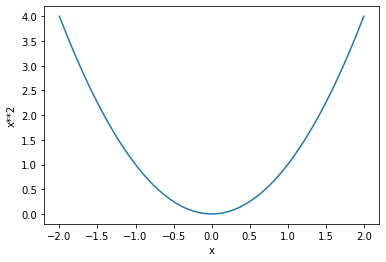

In [53]:
plot_function(f, 'x', 'x**2')

Next, we need to find the bottom value of the graph.  
The steps we described above starts by picking some random value for a parameter and calculating the value of the loss.

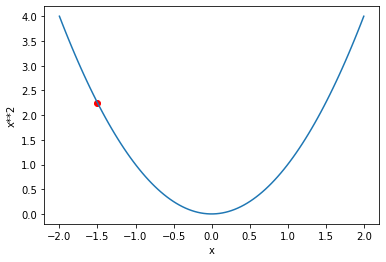

In [54]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

We pick 1.5.

Now we need to know if we increase x a bit, will x**2(the loss in this case) get better(better means the lossis smaller).

To get to the bottom of the curve, we need to calculate the gradient.  
First, we pick a tensor value which we want gradients at:

In [55]:
xt = tensor(3.).requires_grad_()

We will modify this tensor with a special method called requires_grad.  
This method tells PyTorch that anytime I do a calculation with xt, it should do what calculation it does so that I can take the derivative later.  
An underscore(_) at the end of a PyTorch method means that this is called an in-place operation. So it will modify the tensor(3) to tell PyTorch that we want to be calculating gradients on it. 

Now, if we call f on it (Remember f is just squarring it), but the value is not just 9, but 9 accompanied by a grad function (knows that a power has been taken).

In [56]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

So now, we can call a special method called , backward(), which refers to back propagation. This means take the derivative.

In [57]:
yt.backward()

Once it does that we can look inside xt and find its gradient.

In [58]:
xt.grad

tensor(6.)

Remember, the derivative of  x**2 is 2*x, and we have x=3, so the gradients should be 2*3=6.  
The derivative means its a slope. 

Lets repeat the steps with a vector argument(Rank1 tensor).


In [59]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

Let's add sum to our function so that it can take a vector(Rank 1 tensor) and return a scalar(Rank 0 tensor).

In [60]:
def f(x): return(x**2).sum()

yt =f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are 2*xt.

In [61]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradient only tells us the slope of our function but not how far to adjust the parameters. It however gives us an idea.  
If the slope is very large, then wehave more adjustments to do,  whereas if the slope is very small, that may suggest that we are close to the optimal value.

Now, we can do the stepping/changing with a learning rate.
Learning rate -> small number(mostly between 0.001 and 0.1) that we multiply with the gradient so as to change the parameters.  
Once you have a learning rate, you can adjust the parameters with this simple function:
w -= gradient(w) * lr  
w is the weights and lr is the learning rate.  
We subtract all our weights off the gradient multiplied by our learning rate.  
This is the essence of gradient descent, known as stepping our parameters using an optimiser step.

#### Example 2

Let's use gradient descent to solve an actual problem.  
Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:


In [62]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

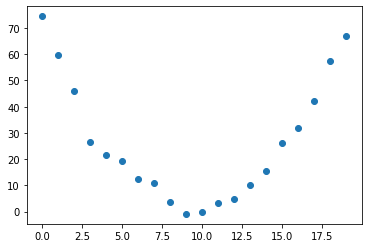

In [63]:
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed)

We want to create a function that estimates at random time, what is the speed of the roller-coaster.  
We start by guessing a function of the form a*(time**2) + (b * time) + c. This is a quadratic functions.  


So let's collect the parameters in one argument and thus separate the input,t, and the parameters, params.  
The parameters are a, b, c.

In [64]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In Python, you can split out a list or collection into its components like this:  
a,b,c = params

We will need to find the best value for a,b,c.  
We can find this choosing a loss function, which will return a value based on a prediction and a target.  
For continous data, it is common to use mean squared error.

In [65]:
def mse(preds, targets): return((preds - targets)**2).mean()

Looking at out 7 steps process:

1) Initialize the weights  
We want to come up with a set of three parameters a, b, c.  
So we initialize a, b, c to random values:

In [66]:
params = torch.randn(3).requires_grad_()

In PyTorch, we get random values using randn() and 3 to state that we want 3 of them.  
Remember, we will be adjusting them so we tell PyTorch we want the gradients.  

In [67]:
#hide
orig_params = params.clone()

Save them this way so we can check them out later.

2) Calculate the predictions

In [68]:
preds = f(time, params)

Let's create a function to see how close our predictions are to our target.

In [69]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

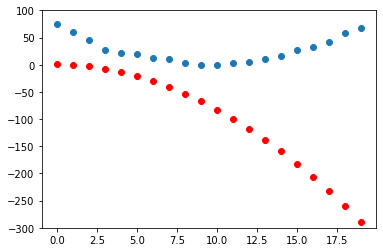

In [70]:
show_preds(preds)

Red is our prediction, Blue is our target.  


This doesn't look very close.

3) Calculate the loss

In [71]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

We need to improve this as the loss is very big.

4) Calculate the gradient

In [72]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

We first call backward() then get grad.  
This says that each of our parameter has a gradient that is negative.

Let's pick a learning rate of 10^-5 or 1e-5 or 0.00001.

In [73]:
params .grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [74]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

5) Step the weights

Remember, stepping the weights means minus equals the learning rate times the gradient.

In [75]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

.data is a special attribute in PyTorch, which if you use it, then the gradient is not calculated.  
We only want the gradient calculated of our function f. So when we step the weight, we have to use .data attribute.

params.grad = None -> deletes the gradients that we already had

Let's see if the loss improved:

In [76]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

plotting this:
    

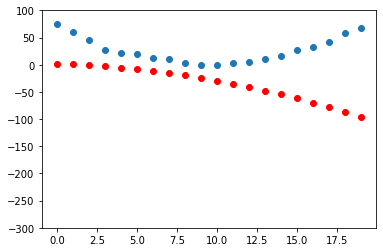

In [77]:
show_preds(preds)

6) Repeat this process a few times

We will create a function with the previous line of code:

In [78]:
def apply_step(params, prn = True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

Iterate 10 times:


In [79]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


We can see the loss decreases.

We can plot this:

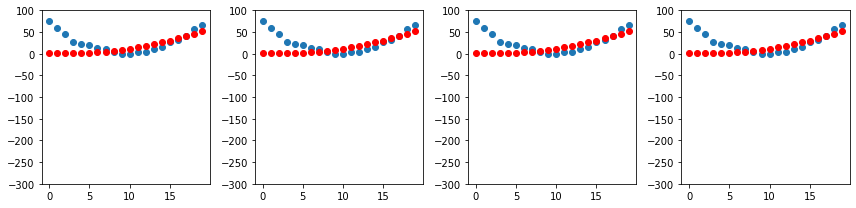

In [80]:
_, axs = plt.subplots(1, 4, figsize = (12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()
                      

7) Stop  
We stop at 10 epochs

## MNIST Loss Function

We need to apply this 7 steps to the MNIST problem.

We need a loss function that represents how good our model is.  
From the loss function, we can calculate our gradient.

Gradient-> measure of how the loss function changes with small tweaks to the weights.  
Gradient/slope = y_new - y_old/ x_new - x_old.

We have x, the images. We'll concatenate them all into a single tensor and also change then from a list of matrices (Rank3 tensor) to a list of vectors (Rank2 tensor).  
This can be achieved by view, a Pytorch method that changes the shape of a tensor without changing its contents.

In [81]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

-1 is a special parameter to view thatmeans make the axis as big as necessary to fit all the data.

We want the number of columns to be equal to the numbet of pixels in the image 28*28.


cat -> concatenate

Now we need labels.  
Our labels will be 1 for each of the 3s and 0 for each of the 7s. This is basically a "is_3" model. This will create a vector and we need it to be matrix in PyTorch.

In [82]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

.unsqueeze(1) will add an additional unit dimension to the position[1]. This will turn up from a vector of 12396 long to a matrix of 12396 rows and one column.

Now we turn our x and y into a Dataset.  
Dataset -> something we can index into, using square brackets and when we do so, its expected to return a tuple of (x, y).

Python provides a zip function which when combined with list, provides a simple way to get this functionality.

In [83]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

We will turn our x and y into dataset and when we index into it, it will return a tuple containing our independent variables, x, and dependent variable, y.

The list() gives us the dataset and when we index into it, it will give us one image,x, and one label,y.

Our image is 784 long vector.

x,y = dset[0] is called destructuring the tuple, which means, we are taking the two parts of the tuple and putting the first part in one variable and secong part in other variable.

Repeat the same step for the validation set:
    

In [84]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Now we will start our 7 step process.

1) Initialize our parameters

In [85]:
def init_params(size, std=1.0): return(torch.randn(size)*std).requires_grad_()

In [86]:
weights = init_params((28*28), 1)

We have a function given some size and shape if you like.  
Then we randomly initialize using normal random number distribution(randn). randn has a variance of 1 (std=1.0).  
Then we tell PyTorch we want gradients.

Our weights will be 28*28 becauseevery pixel is going to need a weight and then 1 because we are going to need to have that unit access to make it a column.

NB: weight*pixels is not going to be enough because it will always be zero when pixels are equal to zero.

Remember y= w*x + b  
we still need b, bias, which is a single number.

Initializing a random number:

In [87]:
bias = init_params(1)

Weights and bias is what makes parameters.  
Parameters is what changes.

2) Calculate the predictions

For one image:

In [88]:
(train_x[0] * weights.T).sum() + bias

/tmp/ipykernel_454/4052062786.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  (train_x[0] * weights.T).sum() + bias


tensor([20.2336], grad_fn=<AddBackward0>)

Here, we take the 1 image and multiply by the wights only to transpose them to make them line up in terms of rowns and columns and add it up and then add the bias. This is the prediction.

We want to do that for every image.  
We could us a for loop but it will be every slow and Python loops don't run on GPUs.

For this reason, a matrix multiplication is the best as it calculates w*x for every row of a matrix.  
In Python, matrix multiplication is represented by the @ operator.

In [89]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([20.2336, 17.0644, 15.2384,  ..., 18.3804, 23.8567, 28.6816], grad_fn=<AddBackward0>)

First element is same as what we had calculated.

This equation, batch@weights + bias, is one of the two fundamental equations of any neural network (the other one is the activation function)

3) Check our accuracy

We can decide that anything greater than 0 we will call it a 3, and anything less than a 0 we call it a 7.

So preds greater than 0.0 tells us whether or not something is predicted to be 3 or not. Then, we turn it to a float(1 or 0) because that's what our training set contains.  
Then we check whether out thresholded predictions are equal to our training set.  
This will return true when predicted correctly and false otherwise.

In [90]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

So if we take the trues and falses and turn them into floats(1s and 0s) and find the mean, its 0.49(almost half with random numbers.

In [91]:
corrects.float().mean().item()

0.49464207887649536

.item() -> without it, the mean would be a tensor.  
It is a rank 0 tensor, has no rows and columns.

This will help us calculate the derivative of our accuracy(by changing the parameters).

4) Change the derivatives

Let's change the weight by small bits:

In [92]:
with torch.no_grad(): weights[0] *= 1.0001

This will make it a bit bigger.

with torch.no_grad() -> tells PyTorch not to calculate the gradient.

In [93]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.49464207887649536

Now we can calculate the predictions based on that. 

As you can see, we get the same number.  
Remember gradient = y_new - y_old/ x_new - x_old  
y_new is what we have now and y_old is what we got(preds = 0.49), the subtraction is 0, and when we divide it by 1.0001(change, x) we get 0.  
This means that the gradient is 0.
This means our step/change is 0 and our prediction will be unchanges like we have seen.  
The reason our gradient is 0 is because when we change a single pixel by a tiny bit, we might not even in any way change an actual prediction to change from a 3 predicting a 3 to a 7 or vice versa because we have the threshold ((preds>0.0).float() == train_y). This means our accuracy loss function here is very bumpy.

Therefore, we need to use another thing other than accuracy as our loss function.

Let's create a new function which will give us a lower loss when the accuracy is better, but it won't have a zero gradient.  
It means a slightly better prediction needs to have a slightly better loss.  
The purpose of this loss function is to measure the difference between the predicted values and true values(target).

Let's make another argument targets, a vector(Rank1) index over the images, with a value of 0 and 1, which tells whether the image is a 3.

Suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (0.9) that the first was a 3, with slight confidence (0.4) that the second was a 7, and with fair confidence (0.2), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [94]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Let's try find a loss function that measures the distance between predictions and targets:

In [95]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, torch.where(a,b,c). This is the same as running the list comprehension [b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

In [96]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

torch.where(targets==1, 1-prds, prds) -> means where target=1, return 1-prediction, and where target is not 1, return predictions.

In the example, first will be 1-0.9=0.1 as the target is 1, next will be 0.4 as the target is 0 and the third will be 1-o.2=0.8 as the target is 1.

As you can see, when the target is correct, the numbers are small(means that the loss is better).

Now we work on the mean:

In [97]:
mnist_loss(prds, trgts)

tensor(0.4333)

Let say we change our prediction for the one "false" target from 0.2 to 0.8 the loss will go down, indicating that this is a better prediction, the loss will get better to 0.23:

In [98]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

Problem: This will only work if predictions are between 0 and 1 so we need to ensure this is the case in the mnist problem.

We need a function that can take the big numbers from our predictions and turn them to numbers between 0 and 1.  
This can be achieved with a sigmoid function.

### Sigmoid Function

Sigmoid function works like this: if you pass a small number, e.g -4, you get a number close to 0, and if you pass a big number you get a number close to 1 but never past 1.
In the middle, the curve looks like a y=x line.

Sigmoid can be defined by:

In [99]:
def sigmoid(x): return 1/(1 + torch.exp(-x))

returns 1/1 + e to minus x.
exp is just e to power something.

In [100]:
math.e

2.718281828459045

this shows the value of e

In [101]:
math.e**2
#squares the value of e

7.3890560989306495

In [102]:
torch.exp(tensor(2.))
#gives same result as above

tensor(7.3891)

Let's update mnist_loss to apply sigmoid to its input:

In [103]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we have a metric(accuracy) and a loss.  
Metric -> the thing we care about.  
Loss -> the thing similar to what we care about but has a nicely behaved gradient.

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

### SDG and mini batches

We need to use this to update the batches. We can do this by:  
- Looping through every image  
- calculate a prediction for that image  
- calculate a loss then  
- step the parameters  
- do that for other images  
This is very slow because we are doing a single step for a single image.

We can go faster by doing a big matrix multiplication on GPU, then we can do a step based on the gradien looking at the entire dataset. But this is a lot of work updating the weights for many images.  
So we can go a few data itema at a timme to calculate our loss and our step.

The few data items are called minibatch.  
The number of items in a minibatch is the batch size.

The larger the batch size means more accurate and stable estimates of your dataset's gradient on the loss function, but it will take longer.

We will use a DataLoader to shuffle and minibatch collation. A DataLoader can take any Python collection and turn it into an iterator over mini-batches, like so:

In [104]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)
     

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

coll = range(15) -> creates a collection that contains all numbers from 1 to 14  
dl = DataLoader(coll, batch_size=5, shuffle=True) -> passes coll to DataLoader with a batch size of 5.    

DataLoader can take any Python collection and turn it into an iterator over many batches. We see it in list(dl).  
shuffle = True -> causes randomization

Remember, datasets return tuples and in the previous code we just have ints. So let's create tuples.  
If we enumerate all letters of English, then we get:

In [105]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

So if we pass this to our DataLoader with a batch size of 6, it returns tuples containing 6 of the first things and the associate 6 of the second.

In [106]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

[17, 18, 10, 22,  8, 14] is like our independent variable, ([17, 18, 10, 22,  8, 14]) is like our dependent variable.

### Putting it all together

It's time to implement the process we saw in <>. In code, our process will be implemented something like this for each epoch:

for x, y in dl:  
    pred = model(x)  
    loss = loss_func(pred, y)  
    loss.backward()  
    parameters -= parameters.grad*lr  

for x, y in dl: -> means for in dataloader return tuple  

x, y destructures dataloader into first and second bit (x, y) then calculates predictions. From predictions and targets, we can calculate our loss. The .backward() will then calculate our gradients. Then we update the parameters.

First, we initialize our parameters:

In [107]:
weights = init_params((28*28, 1))
bias = init_params(1)

A DataLoader can be created from a Dataset:

In [108]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

first() -> fastai function that grabs the first thing from an iterator

Then we display the shape of the first item

xb -> is 256 rows of the 784 long(28*28)  
yb -> 256 labels that are 1(Remember the 0 label for 7s and 1 label for 3s)

We'll do the same for the validation set:

In [109]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [110]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

This manually grabs the first 4 things for testing.

We pass the batch into a linear function that we created earlier:

In [111]:
preds=linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

This will give the prediction of these 4 images.

We can calculate the loss using the loss function we just used and let's grab the first 4 items of the training set:

In [112]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

Now we can calculate the gradient:

In [113]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

torch.Size([784, 1] -> 784*1 is a column where the weights as a grad. It's what the change in loss for a small change in parameter.  
bias.grad (-0.0008) is a sinle number because its a single number.

Put these step in a function:

In [114]:
def calc_grad(xb, yb, model):     #pass the x batch, y batch and model  
    preds = model(xb)             #calculate predictions  
    loss = mnist_loss(preds, yb)  #calculate loss  
    loss.backward()               #do backward step

Test it:

In [115]:
calc_grad(batch, train_y[:4], linear1)   #calculate gradient  
weights.grad.mean(), bias.grad

(tensor(-0.0121), tensor([-0.0840]))

weights.grad.mean() -> mean of weights  
bias.grad -> bias gradient

Call it a second time:

In [116]:
calc_grad(batch, train_y[:4], linear1) 
weights.grad.mean(), bias.grad

(tensor(-0.0182), tensor([-0.1260]))

Here, we get a different value because loss.backward() calculates the gradient and adds them to the existing gradients (In the .grad attribute).  
What we need to do is call grad.zero_().  
.zero returns a tensor containing zeros and _ updates the weights.grad which is a tensor containing zeros.  
If we do that and call it again, we get the same number.

In [117]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

Now we train one epoch with SGD:

In [118]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

First, we loop through the DataLoader, grabbing the x batch and the y batch to calculate the gradient.  
Then we go through each of the parameter(the 784 weights and 1 bias) and for each of those update the parameters to go minus equal gradient times the learning rate.  
This is our Gradient Descent Step.  
Then we zero it out for the next time around the loop.

.data -> special attribute in PyTorch that tells it not to upgate the gradients using that calculation.

This is the most basic Stochastic Gradient Descent.

##### Difference between Stochastic Gradient Descent(SGD) and Gradient Descent(GD).  
GD doesn't have this(for xb, yb in dl:) that loops through each mini batch. GD does it for the whole dataset each time around. So it updates parameters based on the whole dataset (We don't do this in practice, we use minibatches of different sizes)

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [119]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

In [120]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) ==yb
    return correct.float().mean()

We previously checked whether the prediction is less than 0, but since we are doing the sigmoid, sigmoid will squish everything between 0 and 1. So now we should compare the predictions to whether they are grater than 0.5 or not.  
On the sigmoid plot we have, what used to be 0 is now 0.5.

So to calculate the accuracy of the x batch and the y batch, we take the sigmoid of the predictions(xb.sigmoid()) then we compare to 0.5 to tell whether its a 3 or not.  
We check what the actual target(yb) was, to se which ones are correct then we take the mean of those after converting the boolean to float.

We can check if it works:

In [121]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

To check the accuracy, we take the batch put it through our simple linear model, compare it to the 4 items of the training set.

and then put the batches together:

In [122]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)
            

If we do that for every batch in the validation set then we can loop through with a list comprehension (every batch in the validation set), get the accuracy based on some model(2nd line of code).

3rd line of code -> Stack those all up together to turn the list into a tensor, take the mean and convert to a standard Python scalar with .item and round it off to 4 decimal places.

Here's the validation accuracy:

In [123]:
validate_epoch(linear1)

0.5261

It's about 50% because its random.

So now we train for one epoch:

In [124]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

Our accuracy is now 68%.

Now, we repeat it a few times:

In [125]:
for i in range(20):
    train_epoch(linear1,lr,params)
    print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9275 0.9398 0.9466 0.9505 0.9525 0.9559 0.9579 0.9598 0.9608 0.9613 0.9618 0.9633 0.9637 0.9647 0.9657 0.9672 0.9677 

Accuracy goes up to about 97%.

We've built an SGD of a simple linear function that is getting about 97% accuracy.

We can simplify some steps through simple refactoring.  
In the next step, we will create an object that will handle the SGD for us, called an optimizer.

## Creating an Optimizer

1) We'll get rid of the linear1 function

In [126]:
linear1??

Signature: linear1(xb)
Docstring: <no docstring>
Source:    def linear1(xb): return xb@weights + bias
File:      /tmp/ipykernel_454/3366534937.py
Type:      function


Remember it does x @ w + b.  
There's a class in Python that does that called nn.linear module.


Module -> object of a class that inherits from PyTorch class.

nn.linear does two things:  
    - does the linear1 function(x @ w + b) for us.  
    - also initializes the parameters for us so we don't have to do (weights = init_params()) and (bias = init_params())  
    
We just create a nn.linear class and that's going to create a matrix of size(28, 28, 1) and bias of size 1. It will set requires_grad = True for us.  

In [127]:
linear_model = nn.Linear(28 * 28, 1)

When we call the fn, its going to do x @ w + b.

To see the parameters, we would expect it to contain 784 weights and 1 bias, we can just call .parameters():

In [128]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can destructure it to w and b.  
Weights is (1, 784), bias is (1)

Now, we can create an optimizer:

In [129]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -=p.grad.data * self.lr
        
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

init function -> passes the parameter to optimize and learning rate, and stores them away  
step function -> goes through each parameter and does p.data -=p.grad.data * self.lr  
zero_grad function -> goes through each parameter and zeros it out or sets it to None.

This is our Basic Optimizer.

Now we can create an optimizer passing in the parameters of the linear model and our learning rate:

In [130]:
opt = BasicOptim(linear_model.parameters(), lr)

Now our training loop looks through each of the minibatch in the data loader, calculates the gradient, does the opt.step and opt.zero_grad:

In [131]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Validation function doesn't need to change:

In [132]:
validate_epoch(linear_model)

0.4608

So let's put our training loop into a function:

In [133]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

It will loop through a bunch of epochs called train_epoch and print validate_epoch and run it.

In [134]:
train_model(linear_model, 20)

0.4932 0.7685 0.8554 0.9135 0.9345 0.9482 0.957 0.9633 0.9657 0.9677 0.9696 0.9716 0.9736 0.9745 0.976 0.977 0.9775 0.9775 0.978 0.9785 

Results are different, but idea is the same.

We don't need to comre up with BasicOptim, fastai provides SGD class which does the same:

In [135]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8178 0.8496 0.914 0.9345 0.9482 0.957 0.9618 0.9657 0.9672 0.9692 0.9711 0.9741 0.975 0.976 0.9775 0.9775 0.978 0.9785 0.9789 

You can pass to SGD your parameters and learning rate like BasicOptim.  
We get the same result as above.

###### Fastai classes  
- DataLoader -> stores the .train and .valid data.   

- Learner -> we pass in our dataloders, model, optimization function, loss function and metrics

In [136]:
dls = DataLoaders(dl, valid_dl)

In [137]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

It will call train_model and train_epoch.

Now we can call fit:

In [138]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


## Adding Non-Linearity

This was just a linear function, we wanta neural network. Remember x@w + b is a linear function.   

To turn it into a neural network, we have two linear functions exactly the sma ebut with different weights and biases and in between have, res = res.max(tensor(0.0)), which takes the result of our first linear function, res = xb@w1 + b1, and then does a max() between that and 0. So a max() of res and 0 is going to take any negative numbers and turn them into 0s.

A simple net does the following:  
    - Takes a linear function  
    - Replaces negatives with 0s  
    -Takes that and puts it through another linear function  
    
This is a neural network.

In [139]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = xb@w2 + b2

w1 and w2 -> weight tensors  
b1 and b2 -> bias tensors

Initializing them:

In [140]:
w1 = init_params((28*28), 30)
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that 30 to anything you like, to make the model more or less complex.

res = res.max(tensor(0.0)) is called the Rectified Linear Unit(ReLU).  
In PyTorch, it has a function called F.relu. We can plot it:

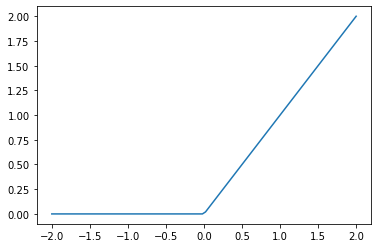

In [141]:
plot_function(F.relu)

As you can see it is 0 for the negative values, and y=x for the positive values.

Why do we do Linear layer ReLU:  
If we get rid of the res = res.max(tensor(0.0)) line, which is the ReLu and just do linear layer then linear layer, we just make a linear model. No matter how many linear layer we stack on each other, it still is a linear layer.  
But if you put a non-linearity module between them, its actually the opposite. This is called Universal Approximation Theorem, which is, if the size of the weights and bias matrices are big enough, it can actually approximate any arbitrary function (including our function of how to recognize 3s and 7s).

The three lines of code that we have here are known as layers. The first and third are known as linear layers, and the second line of code is known variously as a nonlinearity, or activation function.

The simple_net function is our universal approximation function as long as w1, b1, w2, b2 have the right numbers.  
We know how to make them the right numbers using SGD.

Simplifying things:

In [142]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

nn.Sequential -> creates a module which will call each of the listed layers or functions in turn.

In the simple_net function, we are taking the results of one and passing it to the next, then take the results of the next and pass it to the next and returned at the end. This is called Function Composition.  
Composition -. when you take the results of one function and pass it to a new one, take the result and pass it to a new one etc.  
Neural network is just doing function composition of linear functions and these are called Activation Functions or non-linearity.

PyTorch provides nn.Sequential to do activation function for us.

NOTE: We are not using F.ReLU(function) but nn.ReLU(module).

Leaky ReLU -> not to make the ReLU function flat at the values less than 0 as 0 means the neurons are dead/do nothing. It rather makes a less steep line.

Now that we have a neural net, we can use the same learner we had but this time we pass simple_net instead of nn.linear that we use.

In [ ]:
learn = Learner(dls, simple_net, opt_func = SGD, loss_func = mnist_loss, metrics=batch_accuracy)

Now we call fit:

In [ ]:
learn.fit(40, 0.1)

Here,we only have two layers.  
We have dropped ur learning rate from 1 to 0.1 because the deeper models(with more layers) all tend to be bumpier, less nicely behaved so often you need to use lower learning rates.

We can see what the training looks like:

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

This allows us to look inside the learner.  
There's an attribute we create called recorder that records everything in the learn.fit table.  
.itemgot(2) -> gets item number two of the table which is the accuracy.  
L class -> where we have itemgot()

In [ ]:
We can view